# Imports

In [1]:
import numpy as np
import pandas as pd
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import tensorflow as tf
from   tensorflow.keras.callbacks import ModelCheckpoint

# Model Training

## Get Encoded data

In [2]:
model_df = pd.read_csv("charity_data.preprocess.2.one_hot_encoding.csv")

In [3]:
unique_class_count = model_df["APPLICATION_TYPE"].nunique()
print(f"The number of unique catigory values for the feature APPLICATION_TYPE is {unique_class_count}")
unique_class_count = model_df["CLASSIFICATION"].nunique()
print(f"The number of unique catigory values for the feature CLASSIFICATION is {unique_class_count}")

The number of unique catigory values for the feature APPLICATION_TYPE is 17
The number of unique catigory values for the feature CLASSIFICATION is 71


## Model Parameters

In [4]:
feature_appl_other_le_row_cnt = 0

feature_class_other_le_row_cnt = 0

hidden_layer_1_nodes   = 100
hidden_layer_1_act_func = "relu"

hidden_layer_2_nodes   = 125
hidden_layer_2_act_func = "relu"

hidden_layer_3_nodes   = 25
hidden_layer_3_act_func = "relu"

output_layer_nodes = 1
output_layer_act_func = "sigmoid"

In [5]:
def remapp(classification, remap_class_list):
    if classification in remap_class_list:
        return "Other"
    return classification

In [6]:
def set_feature_val_other(feature_Name, le_row_count):
    if le_row_count > 0:
        feature_cat_filt_row_cnt_ser = model_df[feature_Name].value_counts()
        feature_cat_filt_row_cnt_ser = feature_cat_filt_row_cnt_ser[(feature_cat_filt_row_cnt_ser[:] <= le_row_count)]
        model_df[feature_Name] = model_df[feature_Name].apply(remapp, args=[feature_cat_filt_row_cnt_ser.index])
        unique_class_count = model_df[feature_Name].nunique()
        print(f"The number of unique catigory values for the feature {feature_Name} has been reduced to {unique_class_count}")

In [7]:
set_feature_val_other("APPLICATION_TYPE", feature_appl_other_le_row_cnt)

In [8]:
set_feature_val_other("CLASSIFICATION", feature_class_other_le_row_cnt)

## Encoding  APPLICATION_TYPE and CLASSIFICATION Catigorical Fields

In [9]:
# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False, dtype=np.int64)

# Fit and transform the OneHotEncoder using the categorical variable list
encoded_df = pd.DataFrame(encoder.fit_transform(model_df[["APPLICATION_TYPE","CLASSIFICATION"]]))

# Add the encoded variable names to the DataFrame
encoded_df.columns = encoder.get_feature_names(["APPLICATION_TYPE","CLASSIFICATION"])

In [10]:
# Merge one-hot encoded features and drop the originals
model_df.drop(["APPLICATION_TYPE","CLASSIFICATION"],1, inplace=True)
model_df = model_df.merge(encoded_df,left_index=True, right_index=True)

In [11]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_ASK_AMT_scaler = scaler.fit(model_df["ASK_AMT"].values.reshape(-1,1))

# Scale the data
model_df["ASK_AMT"] = X_ASK_AMT_scaler.transform(model_df["ASK_AMT"].values.reshape(-1,1))

In [12]:
for column in model_df.columns:
    print(f"The column:[{column}] has [{len(model_df[column].unique())}] values")

The column:[ASK_AMT] has [8747] values
The column:[IS_SUCCESSFUL] has [2] values
The column:[AFFILIATION_CompanySponsored] has [2] values
The column:[AFFILIATION_Family/Parent] has [2] values
The column:[AFFILIATION_Independent] has [2] values
The column:[AFFILIATION_National] has [2] values
The column:[AFFILIATION_Other] has [2] values
The column:[AFFILIATION_Regional] has [2] values
The column:[USE_CASE_CommunityServ] has [2] values
The column:[USE_CASE_Heathcare] has [2] values
The column:[USE_CASE_Other] has [2] values
The column:[USE_CASE_Preservation] has [2] values
The column:[USE_CASE_ProductDev] has [2] values
The column:[ORGANIZATION_Association] has [2] values
The column:[ORGANIZATION_Co-operative] has [2] values
The column:[ORGANIZATION_Corporation] has [2] values
The column:[ORGANIZATION_Trust] has [2] values
The column:[INCOME_AMT_0] has [2] values
The column:[INCOME_AMT_1-9999] has [2] values
The column:[INCOME_AMT_10000-24999] has [2] values
The column:[INCOME_AMT_10000

In [13]:
# Split our preprocessed data into our features and target arrays
y = model_df["IS_SUCCESSFUL"].values
X = model_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [14]:
# Define the model - deep neural net
number_input_features = len(X_train[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add( tf.keras.layers.Dense(units=hidden_layer_1_nodes, input_dim=number_input_features, activation=hidden_layer_1_act_func))

# Second hidden layer
if hidden_layer_2_nodes > 0:
    nn.add(tf.keras.layers.Dense(units=hidden_layer_2_nodes, activation=hidden_layer_2_act_func))

# Third hidden layer
if hidden_layer_3_nodes > 0:
    nn.add(tf.keras.layers.Dense(units=hidden_layer_3_nodes, activation=hidden_layer_3_act_func))
    
# Output layer
nn.add(tf.keras.layers.Dense(units=output_layer_nodes, activation=output_layer_act_func))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               11400     
_________________________________________________________________
dense_1 (Dense)              (None, 125)               12625     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                3150      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 27,201
Trainable params: 27,201
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=200)

Epoch 1/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5683 - accuracy: 0.7220
Epoch 2/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5507 - accuracy: 0.7322
Epoch 3/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5475 - accuracy: 0.7327
Epoch 4/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5452 - accuracy: 0.7352
Epoch 5/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5438 - accuracy: 0.7354
Epoch 6/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5420 - accuracy: 0.7350
Epoch 7/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5420 - accuracy: 0.7372
Epoch 8/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5402 - accuracy: 0.7377
Epoch 9/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5389 - accuracy: 0.7376
Epoch 10/200
804/804 [==============================] - 1s 2ms/step - loss: 0.5381 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5210 - accuracy: 0.7467
Epoch 161/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5211 - accuracy: 0.7471
Epoch 162/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5211 - accuracy: 0.7454
Epoch 163/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5217 - accuracy: 0.7467
Epoch 164/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5217 - accuracy: 0.7463
Epoch 165/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5213 - accuracy: 0.7467
Epoch 166/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5210 - accuracy: 0.7472
Epoch 167/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5209 - accuracy: 0.7469
Epoch 168/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5210 - accuracy: 0.7464
Epoch 169/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5212 - a

In [17]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

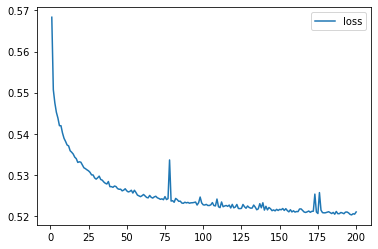

In [18]:
# Plot the loss
history_df.plot(y="loss")

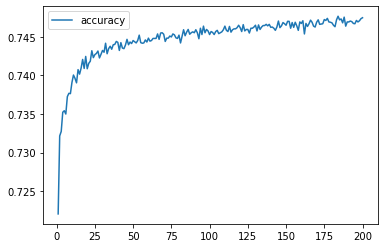

In [19]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6335 - accuracy: 0.7272
Loss: 0.6335379481315613, Accuracy: 0.7272303104400635


In [21]:
# Export our model to HDF5 file
if model_accuracy >= 0.75:
    nn.save("charity_analysis_trained.h5")